# Posterior and Marginal distributions

This notebook is the continuation of `bandwidths.ipynb` notebook, apliying the bw results and the class for get the n-dimentional PDF. 

#### Some considerations: 
1. As **prior** information we will take the cleaned (without NaN or inf values) information from exoplanet.eu, this is the first part of notebook.

2. The PDF from `oiptimal_pdf` class  fulfills the functions of **likelihood** for a certain number of variables in synthetic systems with no-pertutbation, low perturbation and high perturbation. 

3. To get the **marginal** distributions of a variable of interest, we go in the same way that the example marginalization in the notebook `3D.ipynb`.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## 1. Data Cleaning

### 1.1 Simulation data   

see the notation according to <a href="https://github.com/saint-germain/population_synthesis/blob/master/README.md ">Readme.md</a> from `Population_synthesis` project.





In [3]:
#========================== Simulation Data ==========================
dn=pd.read_csv('data/proc_no_pert.csv',index_col=None); dn["gia"]=dn.ngi>0 #without pertubtations 
dl=pd.read_csv('data/proc_lo_pert.csv',index_col=None); dl["gia"]=dl.ngi>0 #with low pertubtations 
dh=pd.read_csv('data/proc_hi_pert.csv',index_col=None); dh["gia"]=dh.ngi>0 #with high pertubtations

In [4]:
len(dh.ms)

1220

### 1.2 Observational data 

Data get from <a href="http://exoplanet.eu/">exoplanet.eu</a>

In [5]:
data_o = pd.read_csv('data/exoplanet.eu_catalog.csv', 
                       usecols = ['mass','mass_error_min','semi_major_axis','semi_major_axis_error_min','star_name',
                                  'star_metallicity','star_metallicity_error_min','star_mass','star_mass_error_min'])

data_o = data_o.replace([np.inf, -np.inf], np.nan) 
data_o = data_o.replace([0], np.nan)
data_o = data_o.dropna()

In [6]:
data_o = data_o[['star_name','mass','mass_error_min', 'semi_major_axis', 'semi_major_axis_error_min', 
                 'star_metallicity', 'star_metallicity_error_min', 'star_mass', 'star_mass_error_min']]

data_o = data_o.assign(CM_i = data_o["semi_major_axis"]*data_o["mass"])
data_o = data_o.assign(dCM_i= data_o["CM_i"]*(data_o["mass_error_min"].divide(data_o["mass"])+data_o["semi_major_axis_error_min"].divide(data_o["semi_major_axis"])))

In [7]:
number=(data_o["star_name"].value_counts()).to_frame()

In [8]:
def NewData(data):
   
    p_system = data.groupby("star_name")
    
    Mtp   = p_system['mass'].sum();             dMtp   = p_system['mass_error_min'].sum();  
    ms    = p_system['star_mass'].mean();        dms    = p_system['star_mass_error_min'].mean()
    metal = p_system['star_metallicity'].mean(); dmetal = p_system['star_metallicity_error_min'].mean()
    
    
    CoM  = p_system['CM_i'].sum().divide(p_system["mass"].sum())
    dCoM = CoM*((p_system['dCM_i'].sum()/p_system['CM_i'].sum()) + (p_system['mass_error_min'].sum())/p_system['mass'].sum())
    
    NewData = pd.DataFrame({'sys_name':list(p_system.groups.keys()),
                            'Mtp':Mtp, 'dMtp':dMtp,
                            'com':CoM.tolist(), 'dcom':dCoM.tolist(), 
                            'ms':ms, 'dms':dms, 'metal':metal, 'dmetal':dmetal})
    return NewData

In [9]:
obs_data = NewData(data_o)
obs_data = obs_data.assign(n_planets = number)
obs_data = obs_data.sort_values(by=['n_planets'], ascending=False)
obs_data.head()

,sys_name,Mtp,dMtp,com,dcom,ms,dms,metal,dmetal,n_planets
star_name,,,,,,,,,,
TRAPPIST-1,TRAPPIST-1,0.017701,0.010374,0.029040,0.034407,0.080,0.007,0.04,0.08,7
K2-138,K2-138,0.113900,0.030500,0.083596,0.053756,0.930,0.060,0.16,0.04,6
GJ 876,GJ 876,2.861000,0.045000,0.185302,0.005413,0.334,0.030,0.05,0.20,4
WASP-47,WASP-47,2.511800,0.097400,0.760462,0.220362,1.110,0.490,0.18,0.07,4
Kepler-289,Kepler-289,0.451000,0.077000,0.489512,0.184174,1.080,0.020,0.05,0.04,3


In [10]:
#system_i = data_o[data_o.star_name == "Kepler-289"]  
#system_i

## 2. Posterior probability 

At first example we take the system "Kepler-289" to get the prior information of stellar mass `ms` and its metallicity `metal`, reported in the catalog of <a href="http://exoplanet.eu/">exoplanet.eu</a>

In [11]:
systm = obs_data[obs_data.sys_name == "Kepler-289"] 
systm

,sys_name,Mtp,dMtp,com,dcom,ms,dms,metal,dmetal,n_planets
star_name,,,,,,,,,,
Kepler-289,Kepler-289,0.451,0.077,0.489512,0.184174,1.08,0.02,0.05,0.04,3


### 2.1 Likelihood
In our formalism, for a variable of interest $x^i_k$, the likelihood of $x^i_k$ given $\boldsymbol\gamma^i$, comes from the model as the sum over unknown parameters $\boldsymbol\alpha^i_k$,

$$p\left(x^{i}_k \mid \boldsymbol\gamma^{i}\right)= \int p_{\text{model}}\left(x^{i}_k, \boldsymbol\alpha^{i}_k \mid \boldsymbol\gamma^{i}\right) d\boldsymbol\alpha^{i}_k.$$

This is implemented in the notebook `optimal_pdf`.

In [12]:
import nbimporter
from bandwidths import optimal_pdf #import the class for get the pdf.

Importing Jupyter notebook from bandwidths.ipynb


In this example we take the variables `dng.ms`, `dng.metal` and `dng.nplanets` 

In [13]:
likelihood = optimal_pdf(dn.ms, dn.metal, dn.nplanets)
likelihood.pdf()

In [14]:
#likelihood.pdf_std

### 2.2 Prior infromation

The prior information $p(\boldsymbol\gamma^{i})$ comes from observations of individual known properties in the pseudovector $\boldsymbol\gamma^{i}$.

To generate a 2D prior $p(\boldsymbol\gamma^{i})$, we multiply a 2D matrix of ones times each prior. Here, we multiply the first prior normaly but for the second prior it is necessary to transpose the previous result. 

$$\text{prior} = ((1_{n\times n}\times Px_n)^{t}\times Py_n)^{t}$$

Finally, we transpose the result to get the prior distribution. For more dimensions the process is the same

In [15]:
from scipy.stats import truncnorm

In [16]:
# per data needs a list with [mu, sigma]: 
#var1 nd var 2 are the variables from simulations args are the list [mu, sigma]:
class prior():
    
    def __init__(self, var1, var2, *args):
        self.lenght = 150
        self.org_data = np.array(args)
        self.pdfs = []         
        self.data = np.vstack([var1,var2]).T
        self.data_std = (self.data-np.mean(self.data, axis=0))/np.std(self.data, axis=0) # standarization     
            
    def prior_pdf(self):
        for i in range(len(self.org_data)):
            x = np.linspace(self.data_std[:,i].min(),
                            self.data_std[:,i].max(),
                            self.lenght)
            pdf = stats.norm.pdf(x,loc = self.org_data[i][0], 
                                 scale = self.org_data[i][1])       
            self.pdfs.append(pdf)
            
        if len(self.org_data) == 2:
            M_ones = np.ones([self.lenght, self.lenght]) 
            prior = ((M_ones*self.pdfs[0]).T*self.pdfs[1]).T     
            
            self.pdf_prior = prior
        
        #return self.pdf_prior 
        #elif len(self.org_data) == 3: 
            #M_ones = np.ones([likelihood.lenght, likelihood.lenght, likelihood.lenght])    
            #prior = (((M_ones*self.pdfs[0]).T*self.pdfs[1]).T*self.pdfs[2]).T 
            #self.pdf_prior = prior

In [17]:
prueba = prior(dn.ms, dn.metal, [systm.ms, systm.dms], [systm.metal,systm.dmetal])
prueba.prior_pdf()

Text(0, 0.5, 'metallicity')

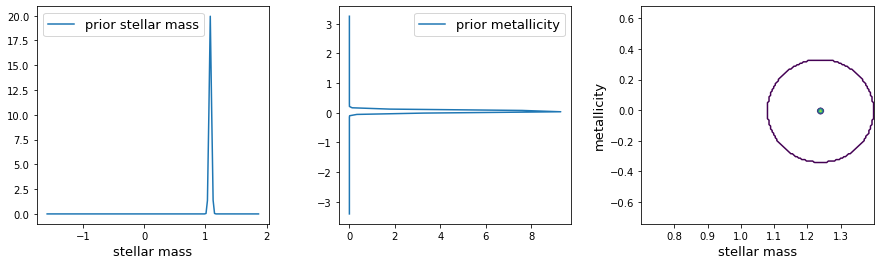

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
fig.subplots_adjust(wspace=.3)
lat = 13
#1
ax[0].plot(likelihood.std_interval[0], prueba.pdfs[0], label = "prior stellar mass")
ax[0].set_xlabel("stellar mass", fontsize =lat)
ax[0].legend(fontsize =lat)
#2
ax[1].plot(prueba.pdfs[1], likelihood.std_interval[1], label = "prior metallicity")
ax[1].legend(fontsize =lat)
#3
ax[2].contour(likelihood.real_interval[0], likelihood.real_interval[1], prueba.pdf_prior)
ax[2].set_xlabel("stellar mass", fontsize =lat)
ax[2].set_ylabel("metallicity", fontsize =lat)


### 2.3 Posterior and marginal distributions

#### Posterior

The posterior distribution comes form Bayes Theorem, then in our formalims:

$$p^\prime\left(x^{i}_k \mid \boldsymbol\gamma^{i}\right) \propto p\left(x^{i}_k \mid \boldsymbol\gamma^{i}\right) p(\boldsymbol\gamma^{i})$$

In therms of the length of data 

$$\boxed{\text{posterior}_{lmn} \propto \text{likelihood}_{lmn} \times \text{prior}_{mn}}$$

Sum the posterior over $l$ is the `axis=0`, $n$ means the `axis=1` and $n$ is the `axis=2`. Finally if we normalize the posterior the above equation becomes into equality.  

So, the posterior is the product of a likelihood with shape $l=100$, $m=100$ and $n=100$ times the prior with shape $m=100$ and $n=100$: 

In [19]:
# likelihood is an object from "class optimal_pdf"
# prior is an object from class "prior"

def posterior(likelihood,prior):
    
    diff = [np.abs(likelihood.data_std[:,i][1] - likelihood.data_std[:,i][0]) for i in range(len(likelihood.data_std[0]))] 

    post = (likelihood.pdf_std.T*prior.pdf_prior.T).T
    
    
    if likelihood.dim == 3:
        norm = ((post.sum(axis=0)*(diff[0])).sum(axis=0)*(diff[1])).sum()*(diff[2])
    
    elif likelihood.dim == 4:
        norm = (((post.sum(axis=0)*(diff[0])).sum(axis=0)*(diff[1])).sum(axis=0)*(diff[2])).sum()*diff[3]
    
    #print((((post/norm)*diff[0]).sum(axis=0)*diff[1]).sum()*diff[2])
    
    return post/norm

In [20]:
pr = prior(dn.ms, dn.metal, [systm.ms, systm.dms], [systm.metal,systm.dmetal])
pr.prior_pdf()

In [21]:
post = posterior(likelihood, pr)

In [22]:
#import plotly.graph_objects as go
#from plotly.subplots import make_subplots

#fig = go.Figure(data=go.Volume(
#    x=likelihood.std_grid[0].flatten(),
#    y=likelihood.std_grid[0].flatten(),
#    z=likelihood.std_grid[0].flatten(),
#    value=post.flatten(),
#    opacity=0.15,     # needs to be small to see through all surfaces
#    surface_count=20, # needs to be a large number for good volume rendering
#    ))
#fig.write_image("images/fig1.pdf")

#### Marginal distriution 

The parginal distribution for a variable of interest is, 

$$p\left(x^{i}_{k}\right)=\int p\left(x^{i}_{k} \mid \boldsymbol\gamma^{i}\right) p(\boldsymbol\gamma^{i})\ d\boldsymbol\gamma^{i}.$$

in other words, 

$$p\left(x^{i}_{k}\right)=\sum_{j=1}^{n} p\left(x^{i}_{k_j} \mid \boldsymbol\gamma^{i}_j\right) p\left(\boldsymbol\gamma^{i}_j\right)\ \Delta \boldsymbol\gamma^{i}_j.$$



In our example, we take stellar mass, metallicity and number of planets. The likelihood came from giant planets obervations without perturbations in its disk structure. 

We will get the marginal distribution $p(x^i_k)$ for our variable of interest $x^{i}_k$ which is the number of planets in the system "Kepler-289".







In [23]:
def marginal(posterior, likelihood):
    
    diff = [np.abs(likelihood.data_std[:,i][1] - likelihood.data_std[:,i][0]) for i in range(len(likelihood.data_std[0]))] 
    #print(diff)
    M  = (posterior.sum(axis=0)*diff[0]).sum(axis=0)*diff[1]
    
    dz = np.abs(likelihood.real_interval[2][1]-likelihood.real_interval[2][0])
    #dz=diff[2] 
    
    norm = (M*dz).sum()
    marginal = M/norm # norm in the real space to work the variable in it space
    
    #print((marginal*dz).sum())
    
    return marginal

In [24]:
Np_marginal = marginal(post, likelihood)

In [25]:
dz = likelihood.real_interval[2][1]-likelihood.real_interval[2][0]
mean = (Np_marginal*likelihood.real_interval[2]*(dz)).sum()

In [26]:
std = ((Np_marginal)*((likelihood.real_interval[2]-mean)**2)*dz).sum()**(1/2.)

In [27]:
inte = np.cumsum(Np_marginal)*dz

p_25 = likelihood.real_interval[2][np.argmin((inte-0.25)**2)]
p_50 = likelihood.real_interval[2][np.argmin((inte-0.50)**2)]
p_75 = likelihood.real_interval[2][np.argmin((inte-0.75)**2)]

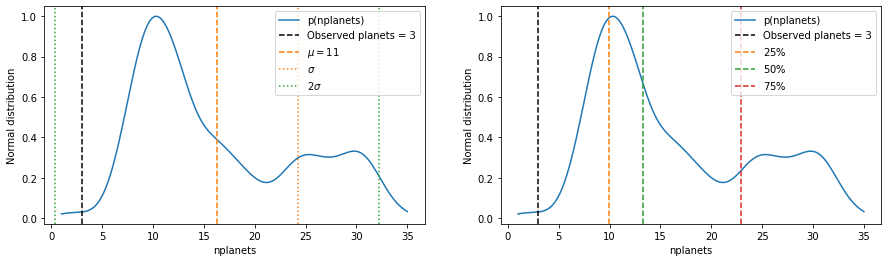

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))

ax[0].plot(likelihood.real_interval[2], Np_marginal/Np_marginal.max(), label="p(nplanets)")
ax[0].set_xlabel("nplanets")
ax[0].set_ylabel("Normal distribution")
ax[0].axvline(x = systm.n_planets.values, ls='--', c="k", label = "Observed planets = 3")
ax[0].axvline(x = mean, ls='--', c="C1", label = r"$\mu = 11$")
ax[0].axvline(x = mean+std, ls=':', c="C1", label = r"$\sigma$")
ax[0].axvline(x = mean+2*std, ls=':', c="C2", label = r"$2\sigma$")
ax[0].axvline(x = mean-2*std, ls=':', c="C2")
ax[0].legend()


ax[1].plot(likelihood.real_interval[2], Np_marginal/Np_marginal.max(), label="p(nplanets)")
ax[1].set_xlabel("nplanets")
ax[1].set_ylabel("Normal distribution")

ax[1].axvline(x = systm.n_planets.values, ls='--', c="k", label = "Observed planets = 3")
ax[1].axvline(x = p_25, ls='--', c="C1", label = r"$25\%$")
ax[1].axvline(x = p_50, ls='--', c="C2", label = r"$50\%$")
ax[1].axvline(x = p_75, ls='--', c="C3", label = r"$75\%$")

ax[1].legend()

#### Posterior and marginal distributions - the class and its methods

In [29]:
#like and prior are pdfs from prior class and optimal_pdf class.
#args are the variables in the same order than likelihood.

class Marginal():
    
    def __init__(self, like, prior, *args):
                
        self.like = like; self.prior= prior 
        self.space = [np.linspace(args[i].min(),args[i].max(), 
                                  150) for i in range(len(args))]
    
        self.data = np.vstack([*args]).T
        self.data_std = (self.data-np.mean(self.data, axis=0))/np.std(self.data, axis=0) # standarization
        
        self.diff  = [np.abs(self.data_std[:,i][1]-self.data_std[:,i][0]) for i in range(len(self.data_std[0]))] 
        self.dz = np.abs(self.space[2][1]-self.space[2][0])
        self.z = self.space[2]
        
    def posterior(self):
        post = (self.like.T*self.prior.T).T
        norm = ((post.sum(axis=0)*(self.diff[0])).sum(axis=0)*(self.diff[1])).sum()*(self.diff[2])
        self.post = post/norm
    
    def pdf(self):
        self.posterior()
        M  = (self.post.sum(axis=0)*self.diff[0]).sum(axis=0)*self.diff[1]
        norm = (M*self.dz).sum()
        self.marginal = M/norm

        inte = np.cumsum(self.marginal)*self.dz

        self.z_mean = (self.marginal*self.z*self.dz).sum()
        self.z_std  = ((self.marginal)*((self.z-self.z_mean)**2)*self.dz).sum()**(1/2.)
        
        self.p_25 = self.z[np.argmin((inte-0.25)**2)]
        self.p_50 = self.z[np.argmin((inte-0.50)**2)]
        self.p_75 = self.z[np.argmin((inte-0.75)**2)]
        
        #return self.marginal

In [30]:
def m_plot(marginal, name):
    like_z = marginal.space[2]
    lat = 12
    plt.plot(like_z, marginal.marginal/marginal.marginal.max(), 
             label = "PDF distribution")
    
    plt.plot(like_z, np.cumsum(marginal.marginal)*marginal.dz)
    
    plt.axvline(x = marginal.p_25, ls='--', c="C1", label = r"$25\%$")
    plt.axvline(x = marginal.p_50, ls='--', c="C2", label = r"$50\%$")
    plt.axvline(x = marginal.p_75, ls='--', c="C3", label = r"$75\%$")
    
    plt.axhline(0.25, lw=.5, ls=":")
    plt.axhline(0.5, lw=.5, ls=":")
    plt.axhline(0.75, lw=.5, ls=":")
    
    plt.xlabel(str(name), fontsize=lat)
    plt.tick_params(axis='both', which='minor', labelsize=lat-2)
    plt.legend(fontsize=lat-1)

# Marginal plots

Below are marginal plots of the selected systems.
The simulation information

In [31]:
dn_1 = pd.read_csv('data/no_p.csv',index_col=None)
dl_1 = pd.read_csv('data/low_p.csv',index_col=None)
dh_1 = pd.read_csv('data/high_p.csv',index_col=None)

In [32]:
dn_1.head()

,ms,metal,md,taugas,com,Mtp,Mjup,Mrock,nplanets,ngi,npt
0,0.880114,0.328146,0.056,1.644711e+06,1.081461,0.032311,13.536323,6454.676716,10.0,4.0,6.0
1,1.075269,-0.150160,0.110,1.014449e+06,2.932894,0.000054,0.000000,17.861989,12.0,0.0,12.0
2,0.861595,0.021273,0.120,1.790533e+06,0.110789,0.007267,0.634259,2217.900297,12.0,1.0,11.0
3,1.076658,-0.282408,0.150,6.017040e+06,5.740174,0.000024,0.000000,8.156892,9.0,0.0,9.0
4,1.206445,-0.174039,0.170,3.956708e+06,0.172211,0.008716,0.702237,2678.844363,13.0,1.0,12.0


In [33]:
dh_1.head()

,ms,metal,md,taugas,com,Mtp,Mjup,Mrock,nplanets,ngi,npt
0,0.880114,0.328146,0.056,1.644711e+06,0.528895,0.017454,4.570196,4358.515866,12.0,3.0,9.0
1,1.075269,-0.150160,0.110,1.014449e+06,2.406300,0.000095,0.007630,29.105223,13.0,1.0,12.0
2,0.861595,0.021273,0.120,1.790533e+06,1.082299,0.017660,2.055159,5226.583846,9.0,1.0,8.0
3,1.076658,-0.282408,0.150,6.017040e+06,7.503351,0.000024,0.000000,7.875300,9.0,0.0,9.0
4,1.206445,-0.174039,0.170,3.956708e+06,5.247285,0.000101,0.008832,30.884136,12.0,1.0,11.0


## Kepler-289 

In [44]:
# System and Prior:
systm = obs_data[obs_data.sys_name == "Kepler-289"] 
prior_kepler = prior(dh_1.ms, dh_1.metal, 
                     [systm.ms, systm.dms], 
                     [systm.metal,systm.dmetal])

prior_kepler.prior_pdf()
prior_kepler = prior_kepler.pdf_prior

In [45]:
likeh_3 = optimal_pdf(dh_1.ms, dh_1.metal, dh_1.nplanets);  likeh_3.pdf()

In [46]:
m9 = Marginal(likeh_3.pdf_std, prior_kepler, dh_1.ms, dh_1.metal, dh_1.nplanets)
m9.pdf()

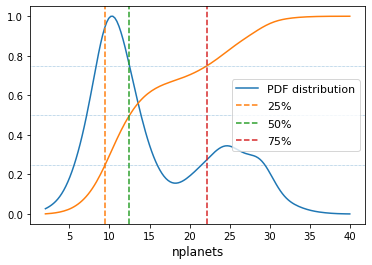

In [47]:
m_plot(m9, "nplanets")

Now all the likelihoods which came as data, as a result of the code `Likelihoods.py`: 

In [57]:
Md  = pd.read_csv('data/likelihoods/like_md.csv',index_col=None)
tau = pd.read_csv('data/likelihoods/like_tgas.csv',index_col=None)
com = pd.read_csv('data/likelihoods/like_com.csv',index_col=None)
mtp = pd.read_csv('data/likelihoods/like_Mtp.csv',index_col=None)
mjup= pd.read_csv('data/likelihoods/like_Mjup.csv',index_col=None)
mrock = pd.read_csv('data/likelihoods/like_Mrock.csv',index_col=None)
ngi = pd.read_csv('data/likelihoods/like_ngi.csv',index_col=None)
ntp = pd.read_csv('data/likelihoods/like_ntp.csv',index_col=None)
nplanets = pd.read_csv('data/likelihoods/like_nplanets.csv',index_col=None)

Now we reshape the likelihood pdf for each variable:

In [58]:
like_Md  = [Md[str(Md.columns[i])].values.reshape(150,150,150) for i in range(1,4)]
like_tau = [tau[str(tau.columns[i])].values.reshape(150,150,150) for i in range(1,4)]
like_com = [com[str(com.columns[i])].values.reshape(150,150,150) for i in range(1,4)]
like_mtp = [mtp[str(mtp.columns[i])].values.reshape(150,150,150) for i in range(1,4)]
like_mjup = [mjup[str(mjup.columns[i])].values.reshape(150,150,150) for i in range(1,4)]
like_mrock = [mrock[str(mrock.columns[i])].values.reshape(150,150,150) for i in range(1,4)]
like_ngi = [ngi[str(ngi.columns[i])].values.reshape(150,150,150) for i in range(1,4)]
like_ntp = [ntp[str(ntp.columns[i])].values.reshape(150,150,150) for i in range(1,4)]
like_nplanets = [nplanets[str(nplanets.columns[i])].values.reshape(150,150,150) for i in range(1,4)]

likelihoods = [like_Md, like_tau, like_com, like_mtp, like_mjup, 
               like_mrock, like_ngi, like_ntp, like_nplanets]

In [64]:
prior_kepler = []

kepler_n = prior(dn_1.ms, dn_1.metal, 
                 [systm.ms, systm.dms], 
                 [systm.metal,systm.dmetal])

kepler_n.prior_pdf()

prior_kepler.append(kepler_n.pdf_prior)



In [75]:
# 1 to 4 because of the number of columns in DataFrames 
# Priors
data = [dn_1, dl_1, dh_1]
prior_kepler = []

for i in range(len(data)):
    
    kepler_n = prior(data[i]["ms"], data[i]["metal"], 
                     [systm.ms, systm.dms], 
                     [systm.metal,systm.dmetal])
    
    kepler_n.prior_pdf()
    prior_kepler.append(kepler_n.pdf_prior)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
marginal_Md = Marginal(like_nplanets[0], kepler_n.pdf_prior, 
                       dn_1.ms, dn_1.metal, dn_1.nplanets); 
marginal_Md.pdf()

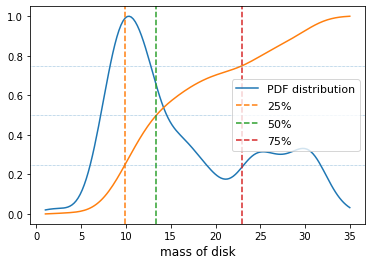

In [56]:
m_plot(marginal_Md, "mass of disk")

In [ ]:
arginal_md = []

In [ ]:
# marginals is an array of marginal distributions for a system, with no, low and high perturbations

#def plot3x3(marginals):
#    fig, ax = plt.subplots(sharey='row', figsize=(13,10))
#    
#    lat=12
#    
#    for i in len(marginals):
#        plt.subplot(3, 3, i)
#        m_plot(marginal.space[i], marginal[0][i])
        
        
        
        
        
        
        
        
    
    

#plt.title("No-perturbations")
#plt.ylabel(r"$p\left(N_t\right)$", fontsize=lat)

#plt.subplot(3, 3, 2)
#plt.title("Low perturbations")
#m_plot(likel_1.real_interval[2], m2, r"$N_t$")
#plt.yticks([])

In [ ]:
#liken_1 = optimal_pdf(dn.ms, dn.metal, dn.nplanets); liken_1.pdf()
#liken_2 = optimal_pdf(dn.ms, dn.metal, dn.md);       liken_2.pdf()
#liken_3 = optimal_pdf(dn.ms, dn.metal, dn.com);      liken_3.pdf()

In [ ]:
#likel_1 = optimal_pdf(dl.ms, dl.metal, dl.nplanets); likel_1.pdf()
#likel_2 = optimal_pdf(dl.ms, dl.metal, dl.md);       likel_2.pdf()
#likel_3 = optimal_pdf(dl.ms, dl.metal, dl.com);      likel_3.pdf()

In [ ]:
#likeh_1 = optimal_pdf(dh.ms, dh.metal, dh.nplanets); likeh_1.pdf()
#likeh_2 = optimal_pdf(dh.ms, dh.metal, dh.md);       likeh_2.pdf()
#likeh_3 = optimal_pdf(dh.ms, dh.metal, dh.com);      likeh_3.pdf()

In [ ]:
#nplanets 
'''
m1 = Marginal(liken_1.pdf_std, prior_kepler, dn.ms, dn.metal, dn.nplanets)
m1.marginal()
m2 = Marginal(likel_1.pdf_std, prior_kepler, dl.ms, dl.metal, dl.nplanets)
m2.marginal()
m3 = Marginal(likeh_1.pdf_std, prior_kepler, dh.ms, dh.metal, dh.nplanets)
m3.marginal()
'''

In [ ]:
#mass disk
'''
m4 = Marginal(liken_2.pdf_std, prior_kepler, dn.ms, dn.metal, dn.md)
m4.marginal()
m5 = Marginal(likel_2.pdf_std, prior_kepler, dl.ms, dl.metal, dl.md)
m5.marginal()
m6 = Marginal(likeh_2.pdf_std, prior_kepler, dh.ms, dh.metal, dh.md)
m6.marginal()
'''

In [ ]:
#CoM
'''
m7 = Marginal(liken_3.pdf_std, prior_kepler, dn.ms, dn.metal, dn.com)
m7.marginal()
m8 = Marginal(likel_3.pdf_std, prior_kepler, dl.ms, dl.metal, dl.com)
m8.marginal()
m9 = Marginal(likeh_3.pdf_std, prior_kepler, dh.ms, dh.metal, dh.com)
m9.marginal()
'''

In [ ]:
'''
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(likeh_3.real_interval[2], m9.marginal/m9.marginal.max())
ax.plot(likeh_3.real_interval[2], np.cumsum(m9.marginal)*m9.dz)

plt.axhline(0.25, lw=.5, ls=':')
plt.axhline(0.5, lw=.5, ls=':')
plt.axhline(0.75,lw=.5, ls=':')

ax.axvline(x = m9.p_25, ls='--', c="C1", label = r"$25\%$")
ax.axvline(x = m9.p_50, ls='--', c="C2", label = r"$50\%$")
ax.axvline(x = m9.p_75, ls='--', c="C3", label = r"$75\%$")

ax.legend()
'''

In [ ]:
'''
fig, ax = plt.subplots(sharey='row', figsize=(13,10))

lat=12

plt.subplot(3, 3, 1)
m_plot(liken_1.real_interval[2], m1, r"$N_t$")
plt.title("No-perturbations")
plt.ylabel(r"$p\left(N_t\right)$", fontsize=lat)

plt.subplot(3, 3, 2)
plt.title("Low perturbations")
m_plot(likel_1.real_interval[2], m2, r"$N_t$")
plt.yticks([])

plt.subplot(3, 3, 3)
plt.title("High perturbations")
m_plot(likeh_1.real_interval[2], m3, r"$N_t$")
plt.yticks([])


plt.subplot(3, 3, 4)
m_plot(liken_2.real_interval[2], m4, r"$M_d$")
plt.ylabel(r"$p\left(M_d\right)$", fontsize=lat)
plt.subplot(3, 3, 5)
m_plot(likel_2.real_interval[2], m5, r"$M_d$")
plt.yticks([])
plt.subplot(3, 3, 6)
m_plot(likeh_2.real_interval[2], m6, r"$M_d$")
plt.yticks([])


plt.subplot(3, 3, 7)
m_plot(liken_3.real_interval[2], m7, r"$r_{cm}$")
plt.ylabel(r"$p\left(r_{cm}\right)$", fontsize=lat)
plt.subplot(3, 3, 8)
m_plot(likel_3.real_interval[2], m8, r"$r_{cm}$")
plt.yticks([])
plt.subplot(3, 3, 9)
m_plot(likeh_3.real_interval[2], m9, r"$r_{cm}$")
plt.yticks([])

plt.subplots_adjust(hspace=0.35)

fig.tight_layout()

plt.savefig("images/kepler-example.pdf")
'''